<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# `WaveToyNRPy`: A simple Einstein Toolkit thorn for solving the (scalar) wave equation

## Authors: Patrick Nelson, Terrence Pierre Jacques, & Zach Etienne
### Formatting improvements courtesy Brandon Clark

[comment]: <> (Abstract: TODO)

**Notebook Status:** <font color='green'><b> Validated</b></font> 

**Validation Notes:** As demonstrated [in the plot below](#code_validation), the numerical error converges to zero at the expected rate.

### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) 
* [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb)

## Introduction:
This tutorial notebook focuses on how to construct an Einstein Toolkit (ETK) thorn (module) that will set up the expressions for the right-hand sides of $\partial_t u$ and $\partial_t v$ for the scalar wave equation, as defined in the [Tutorial-ScalarWave.ipynb](Tutorial-ScalarWave.ipynb) NRPy+ tutorial notebook. In that module, we used NRPy+ to contruct the SymPy expressions for these scalar wave "time-evolution equations". This thorn is largely based on and should function similarly to the `WaveToyC` thorn included in the Einstein Toolkit (ETK) `CactusWave` arrangement. Furthermore, we generate the C kernels for a number of finite difference orders, so that users are free to use a given option at runtime.

When interfaced properly with the ETK, this module will propagate the initial data for $u$ and $v$ defined in [IDScalarWaveNRPy](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb) forward in time by integrating the equations for $\partial_t u$ and $\partial_t v$ subject to spatial boundary conditions. The time evolution itself is handled by the `MoL` (Method of Lines) thorn in the `CactusNumerical` arrangement, and the boundary conditions by the `Boundary` thorn in the `CactusBase` arrangement. Specifically, we implement ETK's `NewRad` boundary condition driver, i.e. a radiation (Sommerfeld) boundary condition. 

Similar to the [IDScalarWaveNRPy](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb) module, we will construct the WaveToyNRPy module in two steps.

1. Call on NRPy+ to convert the SymPy expressions for the evolution equations into one C-code kernel.
1. Write the C code and linkages to the Einstein Toolkit infrastructure (i.e., the .ccl files) to complete this Einstein Toolkit module.

In this Jupyter notebook we parallelize the code generation process for the optimized C code kernels needed for different finite difference options users may choose from at run time. Thus, this Jupyter notebook does not itself run Python code in the relevant C code generation directly. Instead
* code blocks needed to generate the C code kernels (i.e., the C-code representations of the basic equations) are simply output to the `$ScalarWaveETKdir/WaveToyETK_C_kernels_codegen.py` file using the `%%writefile` [IPython magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html);


<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Initialize needed Python/NRPy+ modules
1. [Step 2](#bssn): NRPy+-generated C code kernels for solving the Scalar Wave Equation
    1. [Step 2.a](#swrhs): Scalar Wave RHS expressions
    1. [Step 2.b](#driver_call_codegen_funcs): Generate algorithm for calling corresponding function within `WaveToyETK_C_kernels_codegen_onepart()` to generate C code kernel 
    1. [Step 2.c](#kernel_codegen): Generate C code kernels for `WaveToyNRPy`
        1. [Step 2.c.i](#feature_choice): Set compile-time and runtime parameters for `WaveToyNRPy`
        1. [Step 2.c.ii](#parallel_codegen): Generate all C-code kernels for `WaveToyNRPy`, in parallel if possible
1. [Step 3](#cclfiles): CCL files - Define how this module interacts and interfaces with the wider Einstein Toolkit infrastructure
    1. [Step 3.a](#paramccl): `param.ccl`: specify free parameters within `WaveToyNRPy`
    1. [Step 3.b](#interfaceccl): `interface.ccl`: define needed gridfunctions; provide keywords denoting what this thorn provides and what it should inherit from other thorns
    1. [Step 3.c](#scheduleccl): `schedule.ccl`:schedule all functions used within `WaveToyNRPy`, specify data dependencies within said functions, and allocate memory for gridfunctions
1. [Step 4](#cdrivers): C driver functions for ETK registration & NRPy+-generated kernels
    1. [Step 4.a](#etkfunctions): Needed ETK functions: Banner, Symmetry registration, Parameter sanity check,  Method of Lines (`MoL`) registration, Boundary condition
    1. [Step 4.b](#rhss) Evaluate Scalar Wave right-hand-sides (RHSs)
    1. [Step 4.c](#makecodedefn): `make.code.defn`: List of all C driver functions needed to compile `WaveToyNRPy`
1. [Step 5](#code_validation): Code Validation
    1. [Step 5.a](#planewave): Monochromatic Plane Wave Convergence Tests
    1. [Step 5.b](#gaussian): Spherical Gaussian Wave Convergence Tests
1. [Step 6](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Initialize needed Python/NRPy+ modules \[Back to [top](#toc)\]

$$\label{initializenrpy}$$

In [1]:
ScalarWaveETKdir = "ScalarWave_ETK_py_dir"
import cmdline_helper as cmd  # NRPy+: Multi-platform Python command-line interface
import os, sys, shutil        # Standard Python modules for multiplatform OS-level functions

cmd.mkdir(os.path.join(ScalarWaveETKdir))
# Write an empty __init__.py file in this directory so that Python2 can load modules from it.
with open(os.path.join(ScalarWaveETKdir, "__init__.py"), "w") as file:
    pass

In [2]:
%%writefile $ScalarWaveETKdir/WaveToyETK_C_kernels_codegen.py

# Step 1: Import needed core NRPy+ modules
from outputC import lhrh         # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import loop as lp                # NRPy+: Generate C code loops
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import os, sys                   # Standard Python modules for multiplatform OS-level functions
import time                      # Standard Python module; useful for benchmarking
import ScalarWave.ScalarWaveCurvilinear_RHSs as swrhs

def WaveToyETK_C_kernels_codegen_onepart(params=
        "ThornName=WaveToyNRPy,FD_order=4"):
    # Set default parameters
    ThornName = "WaveToyNRPy"
    FD_order = 4

    import re
    if params != "":
        params2 = re.sub("^,","",params)
        params = params2.strip()
        splitstring = re.split("=|,", params)

#         if len(splitstring) % 2 != 0:
#             print("outputC: Invalid params string: "+params)
#             sys.exit(1)

        parnm = []
        value = []
        for i in range(int(len(splitstring)/2)):
            parnm.append(splitstring[2*i])
            value.append(splitstring[2*i+1])

        for i in range(len(parnm)):
            parnm.append(splitstring[2*i])
            value.append(splitstring[2*i+1])

        for i in range(len(parnm)):
            if parnm[i] == "ThornName":
                ThornName = value[i]
            elif parnm[i] == "FD_order":
                FD_order = int(value[i])
            else:
                print("WaveToyETK Error: Could not parse input param: "+parnm[i])
                sys.exit(1)

    # Set output directory for C kernels
    outdir = os.path.join(ThornName, "src")  # Main C code output directory

    # Set spatial dimension (must be 3 for WaveToy)
    par.set_parval_from_str("grid::DIM",3)

    # Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
    #                                 FD order, floating point precision, and CFL factor:
    # Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
    #              SymTP, SinhSymTP
    # NOTE: Only CoordSystem == Cartesian makes sense here; new
    #       boundary conditions are needed within the ETK for
    #       Spherical, etc. coordinates.
    CoordSystem     = "Cartesian"

    par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
    rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating WaveToy RHSs, etc.

    # Set the gridfunction memory access type to ETK-like, so that finite_difference
    #    knows how to read and write gridfunctions from/to memory.
    par.set_parval_from_str("grid::GridFuncMemAccess","ETK")

Overwriting ScalarWave_ETK_py_dir/WaveToyETK_C_kernels_codegen.py


<a id='scalarwave'></a>

# Step 2: NRPy+-generated C code kernels for solving the Scalar Wave Equation \[Back to [top](#toc)\]

$$\label{scalarwave}$$

<a id='swrhs'></a>

## Step 2.a: Scalar Wave RHS expressions \[Back to [top](#toc)\]
$$\label{swrhs}$$

Here, we simply call the [ScalarWaveCurvilinear.ScalarWaveCurvilinear_RHSs.py](ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py); [\[**tutorial**\]](Tutorial-ScalarWaveCurvilinear.ipynb) NRPy+ Python module to generate the symbolic expressions and then output the finite-difference C code form of the equations using NRPy+'s [finite_difference](finite_difference.py) ([**tutorial**](Tutorial-Finite_Difference_Derivatives.ipynb)) C code generation module.


In [3]:
%%writefile -a $ScalarWaveETKdir/WaveToyETK_C_kernels_codegen.py

    def WaveToy_RHSs__generate_symbolic_expressions():
        ######################################
        # START: GENERATE SYMBOLIC EXPRESSIONS
        print("Generating symbolic expressions for WaveToy RHSs...")
        start = time.time()

        par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
        par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(outdir,"rfm_files/"))

        swrhs.ScalarWaveCurvilinear_RHSs()

        end = time.time()
        print("(BENCH) Finished WaveToy RHS symbolic expressions in "+str(end-start)+" seconds.")
        # END: GENERATE SYMBOLIC EXPRESSIONS
        ######################################

        # Step 2: Register uu_rhs and vv_rhs gridfunctions so
        # they can be written to by NRPy.

        uu_rhs,vv_rhs = gri.register_gridfunctions("AUX",["uu_rhs","vv_rhs"])

        WaveToy_RHSs_SymbExpressions = [\
                        lhrh(lhs=gri.gfaccess("out_gfs","uu_rhs"),rhs=swrhs.uu_rhs),\
                        lhrh(lhs=gri.gfaccess("out_gfs","vv_rhs"),rhs=swrhs.vv_rhs)]

        return WaveToy_RHSs_SymbExpressions

    def WaveToy_RHSs__generate_Ccode(all_RHSs_exprs_list):

        print("Generating C code for WaveToy RHSs (FD_order="+str(FD_order)+") in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
        start = time.time()

        # Store original finite-differencing order:
        FD_order_orig = par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")
        # Set new finite-differencing order:
        par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

        WaveToy_RHSs_string = fin.FD_outputC("returnstring",all_RHSs_exprs_list,
                                          params="outCverbose=False,SIMD_enable=True")

        filename = "WaveToy_RHSs"+"_FD_order_"+str(FD_order)+".h"
        with open(os.path.join(outdir,filename), "w") as file:
            file.write(lp.loop(["i2","i1","i0"],["cctk_nghostzones[2]","cctk_nghostzones[1]","cctk_nghostzones[0]"],
           ["cctk_lsh[2]-cctk_nghostzones[2]","cctk_lsh[1]-cctk_nghostzones[1]","cctk_lsh[0]-cctk_nghostzones[0]"],
                               ["1","1","SIMD_width"],
                                ["#pragma omp parallel for",
                                 "#include \"rfm_files/rfm_struct__SIMD_outer_read2.h\"",
                                 r"""    #include "rfm_files/rfm_struct__SIMD_outer_read1.h"
    #if (defined __INTEL_COMPILER && __INTEL_COMPILER_BUILD_DATE >= 20180804)
        #pragma ivdep         // Forces Intel compiler (if Intel compiler used) to ignore certain SIMD vector dependencies
        #pragma vector always // Forces Intel compiler (if Intel compiler used) to vectorize
    #endif"""],"",
                    "#include \"rfm_files/rfm_struct__SIMD_inner_read0.h\"\n"+WaveToy_RHSs_string))

        # Restore original finite-differencing order:
        par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order_orig)

        end = time.time()
        print("(BENCH) Finished WaveToy_RHS C codegen (FD_order="+str(FD_order)+") in " + str(end - start) + " seconds.")


Appending to ScalarWave_ETK_py_dir/WaveToyETK_C_kernels_codegen.py


<a id='driver_call_codegen_funcs'></a>

## Step 2.b: Generate algorithm for calling corresponding function within `WaveToyETK_C_kernels_codegen_onepart()` to generate C code kernel \[Back to [top](#toc)\]
$$\label{driver_call_codegen_funcs}$$

In [4]:
%%writefile -a $ScalarWaveETKdir/WaveToyETK_C_kernels_codegen.py

    exprs  = WaveToy_RHSs__generate_symbolic_expressions()

    WaveToy_RHSs__generate_Ccode(exprs)

    # Store all NRPy+ environment variables to an output string so NRPy+ environment from within this subprocess can be easily restored
    import pickle
    # https://www.pythonforthelab.com/blog/storing-binary-data-and-serializing/
    outstr = []
    outstr.append(pickle.dumps(len(gri.glb_gridfcs_list)))
    for lst in gri.glb_gridfcs_list:
        outstr.append(pickle.dumps(lst.gftype))
        outstr.append(pickle.dumps(lst.name))
        outstr.append(pickle.dumps(lst.rank))
        outstr.append(pickle.dumps(lst.DIM))

    outstr.append(pickle.dumps(len(par.glb_params_list)))
    for lst in par.glb_params_list:
        outstr.append(pickle.dumps(lst.type))
        outstr.append(pickle.dumps(lst.module))
        outstr.append(pickle.dumps(lst.parname))
        outstr.append(pickle.dumps(lst.defaultval))

    outstr.append(pickle.dumps(len(par.glb_Cparams_list)))
    for lst in par.glb_Cparams_list:
        outstr.append(pickle.dumps(lst.type))
        outstr.append(pickle.dumps(lst.module))
        outstr.append(pickle.dumps(lst.parname))
        outstr.append(pickle.dumps(lst.defaultval))
    return outstr

Appending to ScalarWave_ETK_py_dir/WaveToyETK_C_kernels_codegen.py


<a id='kernel_codegen'></a>

## Step 2.c: Generate C code kernels for `WaveToyNRPy` \[Back to [top](#toc)\]
$$\label{kernel_codegen}$$

Here we generate the C code kernels (i.e., the C-code representation of the equations needed) for `WaveToyNRPy`.

<a id='feature_choice'></a>

### Step 2.c.i: Set compile-time and runtime parameters for `WaveToyNRPy`  \[Back to [top](#toc)\]
$$\label{feature_choice}$$

NRPy+ is a code generation package that is designed to offer maximum flexibility *at the time of C code generation*. As a result, although NRPy+ can in principle output an infinite variety of C code kernels for solving systems of partial differential equations, generally free parameters in each kernel steerable at *runtime* are restricted to simple scalars. This leads to more optimized kernels, but at the expense of flexibility in generating multiple kernels (e.g. one per finite-differencing order). Reducing the number of kernels and adding more flexibility at runtime will be a focus of future work.

For now, `WaveToyNRPy` supports the following runtime options:

* `WaveToyNRPy`: Evolution of the Scalar Wave equation.
    * Finite differencing of orders 2, 4, 6, and 8 via runtime parameter `FD_order`

Next we set up the default parameter lists for `WaveToyETK_C_kernels_codegen_onepart()` for the `WaveToyNRPy` thorn. We set these parameter lists as strings to make parallelizing the code generation far easier (easier to pass a list of strings than a list of function arguments to Python's `multiprocessing.Pool()`).

In [5]:
# Step 2.e.i: Set compile-time and runtime parameters for WaveToy
#         Runtime parameters for
#         WaveToy:       FD_orders = [2,4,6,8]

paramslist = []
FD_orders = [2,4,6,8]
WhichParamSet = 0
ThornName = "WaveToyNRPy"
for FD_order in FD_orders:
    paramstr= "ThornName="+ThornName+","
    paramstr+= "FD_order="+str(FD_order)+","
    paramslist.append(paramstr)
    WhichParamSet = WhichParamSet + 1

paramslist.sort() # Sort the list alphabetically.

<a id='parallel_codegen'></a>

### Step 2.c.ii: Generate all C-code kernels for `WaveToyNRPy`, in parallel if possible \[Back to [top](#toc)\]
$$\label{parallel_codegen}$$

In [6]:
nrpy_dir_path = os.path.join(".")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

# Create all output directories if they do not yet exist
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
import shutil                   # Standard Python module for multiplatform OS-level functions
for ThornName in ["WaveToyNRPy"]:
    outrootdir = ThornName
    cmd.mkdir(os.path.join(outrootdir))
    outdir = os.path.join(outrootdir,"src") # Main C code output directory

    # Copy SIMD/SIMD_intrinsics.h to $outdir/SIMD/SIMD_intrinsics.h, replacing
    #   the line "#define REAL_SIMD_ARRAY REAL" with "#define REAL_SIMD_ARRAY CCTK_REAL"
    #   (since REAL is undefined in the ETK, but CCTK_REAL takes its place)
    cmd.mkdir(os.path.join(outdir,"SIMD"))
    import fileinput
    f = fileinput.input(os.path.join(nrpy_dir_path,"SIMD","SIMD_intrinsics.h"))
    with open(os.path.join(outdir,"SIMD","SIMD_intrinsics.h"),"w") as outfile:
        for line in f:
            outfile.write(line.replace("#define REAL_SIMD_ARRAY REAL", "#define REAL_SIMD_ARRAY CCTK_REAL"))

    # Create directory for rfm_files output
    cmd.mkdir(os.path.join(outdir,"rfm_files"))

# Start parallel C code generation (codegen)
# NRPyEnvVars stores the NRPy+ environment from all the subprocesses in the following
#     parallel codegen
NRPyEnvVars = []

import time   # Standard Python module for benchmarking
import logging
start = time.time()
if __name__ == "__main__":
    try:
        if os.name == 'nt':
            # Windows & Jupyter multiprocessing do not mix, so we run in serial on Windows.
            #  Here's why: https://stackoverflow.com/questions/45719956/python-multiprocessing-in-jupyter-on-windows-attributeerror-cant-get-attribut
            raise Exception("Parallel codegen currently not available in Windows")
        # Step 3.d.ii: Import the multiprocessing module.
        import multiprocessing
        print("***************************************")
        print("Starting parallel C kernel codegen...")
        print("***************************************")

        # Step 3.d.iii: Define master function for parallelization.
        #           Note that lambdifying this doesn't work in Python 3
        def master_func(i):
            import ScalarWave_ETK_py_dir.WaveToyETK_C_kernels_codegen as WCk
            return WCk.WaveToyETK_C_kernels_codegen_onepart(params=paramslist[i])

        # Step 3.d.iv: Evaluate list of functions in parallel if possible;
        #           otherwise fallback to serial evaluation:
        pool = multiprocessing.Pool() #processes=len(paramslist))
        NRPyEnvVars.append(pool.map(master_func,range(len(paramslist))))
        pool.terminate()
        pool.join()
    except:
        logging.exception("Ignore this warning/backtrace if on a system in which serial codegen is necessary:")
        print("***************************************")
        print("Starting serial C kernel codegen...")
        print("(If you were running in parallel before,")
        print(" this means parallel codegen failed)")
        print("***************************************")
        # Steps 3.d.ii-iv, alternate: As fallback, evaluate functions in serial.
        #       This will happen on Android and Windows systems
        import ScalarWave_ETK_py_dir.WaveToyETK_C_kernels_codegen as WCk
        import grid as gri
        for param in paramslist:
            gri.glb_gridfcs_list = []
            WCk.WaveToyETK_C_kernels_codegen_onepart(params=param)
        NRPyEnvVars = [] # Reset NRPyEnvVars in case multiprocessing wrote to it and failed.
# # Steps 3.d.ii-iv, alternate: As fallback, evaluate functions in serial.
# #       This will happen on Android and Windows systems
# for param in paramslist:
#     import grid as gri
#     gri.glb_gridfcs_list = []
#     import ScalarWave_ETK_py_dir.WaveToyETK_C_kernels_codegen as WCk
#     NRPyEnvVars.append(WCk.WaveToyETK_C_kernels_codegen_onepart(params=param))

print("(BENCH) Finished C kernel codegen for WaveToy in "+str(time.time()-start)+" seconds.")

***************************************
Starting parallel C kernel codegen...
***************************************
Generating symbolic expressions for WaveToy RHSs...Generating symbolic expressions for WaveToy RHSs...

Generating symbolic expressions for WaveToy RHSs...
Generating symbolic expressions for WaveToy RHSs...
(BENCH) Finished WaveToy RHS symbolic expressions in 0.01595902442932129 seconds.(BENCH) Finished WaveToy RHS symbolic expressions in 0.01606130599975586 seconds.

Generating C code for WaveToy RHSs (FD_order=2) in Cartesian coordinates.Generating C code for WaveToy RHSs (FD_order=4) in Cartesian coordinates.

(BENCH) Finished WaveToy RHS symbolic expressions in 0.01991891860961914 seconds.
Generating C code for WaveToy RHSs (FD_order=6) in Cartesian coordinates.
(BENCH) Finished WaveToy RHS symbolic expressions in 0.020931720733642578 seconds.
Generating C code for WaveToy RHSs (FD_order=8) in Cartesian coordinates.
(BENCH) Finished WaveToy_RHS C codegen (FD_order=

In [7]:
# Store all NRPy+ environment variables to file so NRPy+ environment from within this subprocess can be easily restored
import pickle                   # Standard Python module for converting arbitrary data structures to a uniform format.
import grid as gri              # NRPy+: Functions having to do with numerical grids
import NRPy_param_funcs as par  # NRPy+: Parameter interface

if len(NRPyEnvVars) > 0:
    # https://www.pythonforthelab.com/blog/storing-binary-data-and-serializing/
    grfcs_list = []
    param_list = []
    Cparm_list = []

    for WhichParamSet in NRPyEnvVars[0]:
        # gridfunctions
        i=0
        # print("Length of WhichParamSet:",str(len(WhichParamSet)))
        num_elements = pickle.loads(WhichParamSet[i]); i+=1
        for lst in range(num_elements):
            grfcs_list.append(gri.glb_gridfc(gftype=pickle.loads(WhichParamSet[i+0]),
                                             name  =pickle.loads(WhichParamSet[i+1]),
                                             rank  =pickle.loads(WhichParamSet[i+2]),
                                             DIM   =pickle.loads(WhichParamSet[i+3]))) ; i+=4
        # parameters
        num_elements = pickle.loads(WhichParamSet[i]); i+=1
        for lst in range(num_elements):
            param_list.append(par.glb_param(type      =pickle.loads(WhichParamSet[i+0]),
                                            module    =pickle.loads(WhichParamSet[i+1]),
                                            parname   =pickle.loads(WhichParamSet[i+2]),
                                            defaultval=pickle.loads(WhichParamSet[i+3]))) ; i+=4
        # Cparameters
        num_elements = pickle.loads(WhichParamSet[i]); i+=1
        for lst in range(num_elements):
            Cparm_list.append(par.glb_Cparam(type      =pickle.loads(WhichParamSet[i+0]),
                                             module    =pickle.loads(WhichParamSet[i+1]),
                                             parname   =pickle.loads(WhichParamSet[i+2]),
                                             defaultval=pickle.loads(WhichParamSet[i+3]))) ; i+=4
    grfcs_list_uniq = []
    for gf_ntuple_stored in grfcs_list:
        found_gf = False
        for gf_ntuple_new in grfcs_list_uniq:
            if gf_ntuple_new == gf_ntuple_stored:
                found_gf = True
        if found_gf == False:
            grfcs_list_uniq.append(gf_ntuple_stored)

    param_list_uniq = []
    for pr_ntuple_stored in param_list:
        found_pr = False
        for pr_ntuple_new in param_list_uniq:
            if pr_ntuple_new == pr_ntuple_stored:
                found_pr = True
        if found_pr == False:
            param_list_uniq.append(pr_ntuple_stored)

    # Set glb_paramsvals_list:
    # Step 1: Reset all paramsvals to their defaults
    par.glb_paramsvals_list = []
    for parm in param_list_uniq:
        par.glb_paramsvals_list.append(parm.defaultval)

    Cparm_list_uniq = []
    for Cp_ntuple_stored in Cparm_list:
        found_Cp = False
        for Cp_ntuple_new in Cparm_list_uniq:
            if Cp_ntuple_new == Cp_ntuple_stored:
                found_Cp = True
        if found_Cp == False:
            Cparm_list_uniq.append(Cp_ntuple_stored)

    gri.glb_gridfcs_list = []
    par.glb_params_list  = []
    par.glb_Cparams_list = []

    gri.glb_gridfcs_list = grfcs_list_uniq
    par.glb_params_list  = param_list_uniq
    par.glb_Cparams_list = Cparm_list_uniq

<a id='cclfiles'></a>

# Step 3: ETK `ccl` file generation \[Back to [top](#toc)\]
$$\label{cclfiles}$$

<a id='paramccl'></a>

## Step 3.a: `param.ccl`: specify free parameters within `WaveToyNRPy` \[Back to [top](#toc)\]
$$\label{paramccl}$$

All parameters necessary for the computation of the Scalar Wave right-hand side (RHS) expressions are registered within NRPy+; we use this information to automatically generate `param.ccl`. NRPy+ also specifies default values for each parameter. 

More information on `param.ccl` syntax can be found in the  [official Einstein Toolkit documentation](https://einsteintoolkit.org/usersguide/UsersGuide.html#x1-184000D2.3).

In [8]:
def keep_param__return_type(paramtuple):
    keep_param = True # We'll not set some parameters in param.ccl;
                      #   e.g., those that should be #define'd like M_PI.
    typestring = ""
    # Separate thorns within the ETK take care of grid/coordinate parameters;
    #   thus we ignore NRPy+ grid/coordinate parameters:
    if paramtuple.module == "grid" or paramtuple.module == "reference_metric":
        keep_param = False

    partype = paramtuple.type
    if partype == "bool":
        typestring += "BOOLEAN "
    elif partype == "REAL":
        if paramtuple.defaultval != 1e300: # 1e300 is a magic value indicating that the C parameter should be mutable
            typestring += "CCTK_REAL "
        else:
            keep_param = False
    elif partype == "int":
        typestring += "CCTK_INT "
    elif partype == "#define":
        keep_param = False
    elif partype == "char":
        # FIXME: char/string parameter types should in principle be supported
        print("Error: parameter "+paramtuple.module+"::"+paramtuple.parname+
              " has unsupported type: \""+ paramtuple.type + "\"")
        sys.exit(1)
    else:
        print("Error: parameter "+paramtuple.module+"::"+paramtuple.parname+
              " has unsupported type: \""+ paramtuple.type + "\"")
        sys.exit(1)
    return keep_param, typestring

with open(os.path.join(outrootdir,"param.ccl"), "w") as file:
    file.write("""
# This param.ccl file was automatically generated by NRPy+.
#   You are advised against modifying it directly.

restricted:
CCTK_REAL wavespeed "The speed at which the wave propagates"
{
 *:* :: "Wavespeed as a multiple of c"
} 1.0

restricted:

CCTK_INT FD_order "Finite-differencing order"
{\n""")
    FDorders = []
    for _root, _dirs, files in os.walk(os.path.join(ThornName,"src")): # _root,_dirs unused.
        for Cfilename in files:
            if (".h" in Cfilename) and ("RHSs" in Cfilename) and ("FD" in Cfilename) and ("intrinsics" not in Cfilename):
                array = Cfilename.replace(".","_").split("_")
                FDorders.append(int(array[-2]))
    FDorders.sort()
    for order in FDorders:
        file.write(" "+str(order)+":"+str(order)+"   :: \"finite-differencing order = "+str(order)+"\"\n")
    FDorder_default = 4
    if FDorder_default not in FDorders:
        print("WARNING: 4th-order FD kernel was not output!?! Changing default FD order to "+str(FDorders[0]))
        FDorder_default = FDorders[0]
    file.write("} "+str(FDorder_default)+ "\n\n") # choose 4th order by default, consistent with ML_WaveToy

<a id='interfaceccl'></a>

## Step 3.b: `interface.ccl`: define needed gridfunctions; provide keywords denoting what this thorn provides and what it should inherit from other thorns \[Back to [top](#toc)\]
$$\label{interfaceccl}$$

`interface.ccl` declares all gridfunctions and determines how `WaveToyNRPy` interacts with other Einstein Toolkit thorns.

The [official Einstein Toolkit documentation](https://einsteintoolkit.org/usersguide/UsersGuide.html#x1-179000D2.2) defines what must/should be included in an `interface.ccl` file. 

In [9]:
evol_gfs_list    = []
for i in range(len(gri.glb_gridfcs_list)):
    if gri.glb_gridfcs_list[i].gftype == "EVOL":
        evol_gfs_list.append(   gri.glb_gridfcs_list[i].name+"GF")

# NRPy+'s finite-difference code generator assumes gridfunctions
#    are alphabetized; not sorting may result in unnecessary
#    cache misses.
evol_gfs_list.sort()

with open(os.path.join(outrootdir,"interface.ccl"), "w") as file:
    file.write("""
# With "implements", we give our thorn its unique name.
implements: WaveToyNRPy

# By "inheriting" other thorns, we tell the Toolkit that we
#   will rely on variables/function that exist within those
#   functions.
inherits: Boundary grid MethodofLines

# Needed functions and #include's:
USES INCLUDE: Symmetry.h
USES INCLUDE: Boundary.h

# Needed Method of Lines function
CCTK_INT FUNCTION MoLRegisterEvolvedGroup(CCTK_INT IN EvolvedIndex,                                           CCTK_INT IN RHSIndex)
REQUIRES FUNCTION MoLRegisterEvolvedGroup

# Needed Boundary Conditions function
CCTK_INT FUNCTION GetBoundarySpecification(CCTK_INT IN size, CCTK_INT OUT ARRAY nboundaryzones, CCTK_INT OUT ARRAY is_internal, CCTK_INT OUT ARRAY is_staggered, CCTK_INT OUT ARRAY shiftout)
USES FUNCTION GetBoundarySpecification

CCTK_INT FUNCTION SymmetryTableHandleForGrid(CCTK_POINTER_TO_CONST IN cctkGH)
USES FUNCTION SymmetryTableHandleForGrid

CCTK_INT FUNCTION Boundary_SelectVarForBC(CCTK_POINTER_TO_CONST IN GH, CCTK_INT IN faces, CCTK_INT IN boundary_width, CCTK_INT IN table_handle, CCTK_STRING IN var_name, CCTK_STRING IN bc_name)
USES FUNCTION Boundary_SelectVarForBC

# Needed for EinsteinEvolve/NewRad outer boundary condition driver:
CCTK_INT FUNCTION                         \
    NewRad_Apply                          \
        (CCTK_POINTER_TO_CONST IN cctkGH, \
         CCTK_REAL ARRAY IN var,          \
         CCTK_REAL ARRAY INOUT rhs,       \
         CCTK_REAL IN var0,               \
         CCTK_REAL IN v0,                 \
         CCTK_INT IN radpower)
REQUIRES FUNCTION NewRad_Apply

# Tell the Toolkit that we want all gridfunctions
#    to be visible to other thorns by using
#    the keyword "public". Note that declaring these
#    gridfunctions *does not* allocate memory for them;
#    that is done by the schedule.ccl file.

# FIXME: add info for symmetry conditions:
#    https://einsteintoolkit.org/thornguide/CactusBase/SymBase/documentation.html

""")

# Next we declare gridfunctions based on their corresponding gridfunction groups as registered within NRPy+

    def output_list_of_gfs(gfs_list,description="User did not provide description"):
        gfsstr = "    "
        for i in range(len(gfs_list)):
            gfsstr += gfs_list[i]
            if i != len(gfs_list)-1:
                gfsstr += "," # This is a comma-separated list of gridfunctions
            else:
                gfsstr += "\n} \""+description+"\"\n\n"
        return gfsstr
    # First EVOL type:
    file.write("public:\n")
    file.write("cctk_real scalar_fields type = GF Timelevels=3 tags=\'tensortypealias=\"Scalar\"\'\n{\n")
    file.write(output_list_of_gfs(evol_gfs_list,"The evolved scalar fields"))
    # Second EVOL right-hand-sides
    file.write("public:\n")
    file.write("cctk_real scalar_fields_rhs type = GF Timelevels=3 tags=\'tensortypealias=\"Scalar\"\'\n{\n")
    rhs_list = []
    for gf in evol_gfs_list:
        rhs_list.append(gf.replace("GF","")+"_rhsGF")
    file.write(output_list_of_gfs(rhs_list,"The rhs of the scalar fields"))


<a id='scheduleccl'></a>

## Step 3.c: `schedule.ccl`: schedule all functions used within `WaveToyNRPy`, specify data dependencies within said functions, and allocate memory for gridfunctions \[Back to [top](#toc)\]
$$\label{scheduleccl}$$

Official documentation on constructing ETK `schedule.ccl` files is found [here](https://einsteintoolkit.org/usersguide/UsersGuide.html#x1-187000D2.4).

In [10]:
with open(os.path.join(outrootdir,"schedule.ccl"), "w") as file:
    file.write("""
# Allocate storage for all 2 gridfunction groups used in WaveToyNRPy
STORAGE: scalar_fields_rhs[3]
STORAGE: scalar_fields[3]

# The following scheduler is based on Lean/LeanBSSNMoL/schedule.ccl

schedule WaveToyNRPy_Banner at STARTUP
{
  LANG: C
  OPTIONS: meta
} "Output ASCII art banner"

schedule WaveToyNRPy_Symmetry_registration at BASEGRID
{
  LANG: C
  OPTIONS: Global
} "Register symmetries, the CartGrid3D way."

schedule WaveToyNRPy_zero_rhss at BASEGRID after WaveToyNRPy_Symmetry_registration
{
  LANG: C
} "Idea from Lean: set all rhs functions to zero to prevent spurious nans"


schedule GROUP ApplyBCs as WaveToyNRPy_ApplyBCs at CCTK_INITIAL
{
} "Apply boundary conditions"


# MoL: registration

schedule WaveToyNRPy_MoL_registration in MoL_Register
{
  LANG: C
  OPTIONS: META
} "Register variables for MoL"


# MoL: compute RHSs, etc

schedule WaveToyNRPy_set_rhs as WaveToy_Evolution IN MoL_CalcRHS
{
  LANG: C
  READS: uuGF(Everywhere)
  READS: vvGF(Everywhere)
  WRITES: uu_rhsGF(Interior)
  WRITES: vv_rhsGF(Interior)
} "Evolution of 3D wave equation"

schedule WaveToyNRPy_NewRad in MoL_CalcRHS after WaveToyNRPy_RHS
{
  LANG: C
} "NewRad boundary conditions, scheduled right after RHS eval."

schedule WaveToyNRPy_BoundaryConditions_register_evolved_gfs in MoL_PostStep
{
  LANG: C
  OPTIONS: LEVEL
  SYNC: scalar_fields
} "Apply boundary conditions and perform AMR+interprocessor synchronization"

schedule GROUP ApplyBCs as WaveToyNRPy_ApplyBCs in MoL_PostStep after WaveToyNRPy_BoundaryConditions_register_evolved_gfs
{
} "Group for applying boundary conditions"
""")

<a id='cdrivers'></a>

# Step 4: C driver functions for ETK registration & NRPy+-generated kernels \[Back to [top](#toc)\]
$$\label{cdrivers}$$

Now that we have constructed the basic C code kernels and the needed Einstein Toolkit `ccl` files, we next write the driver functions for registering `WaveToyNRPy` within the Toolkit and the C code kernels. Each of these driver functions is called directly from [`schedule.ccl`](#scheduleccl).

<a id='etkfunctions'></a>
## Step 4.a: Needed ETK functions: Banner, Symmetry registration, Parameter sanity check,  Method of Lines (`MoL`) registration, Boundary condition \[Back to [top](#toc)\]
$$\label{etkfunctions}$$

### To-do: Parameter sanity check function. E.g., error should be thrown if `cctk_nghostzones[]` is set too small for the chosen finite-differencing order within NRPy+.

In [11]:
make_code_defn_list = []
def append_to_make_code_defn_list(filename):
    if filename not in make_code_defn_list:
        make_code_defn_list.append(filename)
    return os.path.join(outdir,filename)

In [12]:
# First the ETK banner code, proudly showing the NRPy+ banner
import NRPy_logo as logo

with open(append_to_make_code_defn_list("Banner.c"),"w") as file:
    file.write("""
#include <stdio.h>

void WaveToyNRPy_Banner()
{
    """)
    logostr = logo.print_logo(print_to_stdout=False)
    file.write("printf(\"WaveToyNRPy: another Einstein Toolkit thorn generated by\\n\");\n")
    for line in logostr.splitlines():
        file.write("    printf(\""+line+"\\n\");\n")
    file.write("}\n")

In [13]:
# Next register symmetries
with open(append_to_make_code_defn_list("Symmetry_registration_oldCartGrid3D.c"),"w") as file:
    file.write("""
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "Symmetry.h"

void WaveToyNRPy_Symmetry_registration(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  // Stores gridfunction parity across x=0, y=0, and z=0 planes, respectively
  int sym[3];

  // Next register parities for each gridfunction based on its name
  //    (to ensure this algorithm is robust, gridfunctions with integers
  //     in their base names are forbidden in NRPy+).
""")
    full_gfs_list = []
    full_gfs_list.extend(evol_gfs_list)
    for gf in full_gfs_list:
        file.write("""
  // Default to scalar symmetry:
  sym[0] = 1; sym[1] = 1; sym[2] = 1;
  // Now modify sym[0], sym[1], and/or sym[2] as needed
  //    to account for gridfunction parity across
  //    x=0, y=0, and/or z=0 planes, respectively
""")
        # If gridfunction name does not end in a digit, by NRPy+ syntax, it must be a scalar
        if gf[len(gf) - 1].isdigit() == False:
            pass # Scalar = default
        elif len(gf) > 2:
            # Rank-1 indexed expression (e.g., vector)
            if gf[len(gf) - 2].isdigit() == False:
                if int(gf[-1]) > 2:
                    print("Error: Found invalid gridfunction name: "+gf)
                    sys.exit(1)
                symidx = gf[-1]
                file.write("  sym["+symidx+"] = -1;\n")
            # Rank-2 indexed expression
            elif gf[len(gf) - 2].isdigit() == True:
                if len(gf) > 3 and gf[len(gf) - 3].isdigit() == True:
                    print("Error: Found a Rank-3 or above gridfunction: "+gf+", which is at the moment unsupported.")
                    print("It should be easy to support this if desired.")
                    sys.exit(1)
                symidx0 = gf[-2]
                file.write("  sym["+symidx0+"] *= -1;\n")
                symidx1 = gf[-1]
                file.write("  sym["+symidx1+"] *= -1;\n")
        else:
            print("Don't know how you got this far with a gridfunction named "+gf+", but I'll take no more of this nonsense.")
            print("   Please follow best-practices and rename your gridfunction to be more descriptive")
            sys.exit(1)
        file.write("  SetCartSymVN(cctkGH, sym, \"WaveToyNRPy::"+gf+"\");\n")
    file.write("}\n")

In [14]:
# Next register symmetries
import loop as lp                # NRPy+: Generate C code loops
with open(append_to_make_code_defn_list("zero_rhss.c"),"w") as file:
    file.write("""
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "Symmetry.h"

void WaveToyNRPy_zero_rhss(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
""")
    set_rhss_to_zero = ""
    for gf in rhs_list:
        set_rhss_to_zero += gf+"[CCTK_GFINDEX3D(cctkGH,i0,i1,i2)] = 0.0;\n"

    file.write(lp.loop(["i2","i1","i0"],["0", "0", "0"],
                       ["cctk_lsh[2]","cctk_lsh[1]","cctk_lsh[0]"],
                       ["1","1","1"],
                        ["#pragma omp parallel for","","",],"",set_rhss_to_zero))
    file.write("}\n")

In [15]:
# Next registration with the Method of Lines thorn
with open(append_to_make_code_defn_list("MoL_registration.c"),"w") as file:
    file.write("""
//--------------------------------------------------------------------------
// Register with the Method of Lines time stepper
// (MoL thorn, found in arrangements/CactusBase/MoL)
// MoL documentation located in arrangements/CactusBase/MoL/doc
//--------------------------------------------------------------------------
#include <stdio.h>

#include "cctk.h"
#include "cctk_Parameters.h"
#include "cctk_Arguments.h"

#include "Symmetry.h"

void WaveToyNRPy_MoL_registration(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  CCTK_INT ierr = 0, group, rhs;

  // Register evolution & RHS gridfunction groups with MoL, so it knows

  group = CCTK_GroupIndex("WaveToyNRPy::scalar_fields");
  rhs = CCTK_GroupIndex("WaveToyNRPy::scalar_fields_rhs");
  ierr += MoLRegisterEvolvedGroup(group, rhs);

  if (ierr) CCTK_ERROR("Problems registering with MoL");
}
""")

In [16]:
# Next register with the boundary conditions thorns.
# PART 1: Set BC type to "none" for all variables
# Since we choose NewRad boundary conditions, we must register all
#   gridfunctions to have boundary type "none". This is because
#   NewRad is seen by the rest of the Toolkit as a modification to the
#   RHSs.

# This code is based on Kranc's McLachlan/ML_BSSN/src/Boundaries.cc code.
with open(append_to_make_code_defn_list("BoundaryConditions_register_evolved_gfs.c"),"w") as file:
    file.write("""
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "cctk_Faces.h"
#include "util_Table.h"
#include "Symmetry.h"

// Set `none` boundary conditions on RHSs, as these are set via NewRad.
void WaveToyNRPy_BoundaryConditions_register_evolved_gfs(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  CCTK_INT ierr CCTK_ATTRIBUTE_UNUSED = 0;
""")
    for gf in evol_gfs_list:
        file.write("""
  ierr = Boundary_SelectVarForBC(cctkGH, CCTK_ALL_FACES, 1, -1, "WaveToyNRPy::"""+gf+"""", "none");
  if (ierr < 0) CCTK_ERROR("Failed to register BC for WaveToyNRPy::"""+gf+"""!");

""")
    file.write("}")

# PART 2: Set C code for calling NewRad BCs
#   As explained in lean_public/LeanBSSNMoL/src/calc_bssn_rhs.F90,
#   the function NewRad_Apply takes the following arguments:
#   NewRad_Apply(cctkGH, var, rhs, var0, v0, radpower),
#     which implement the boundary condition:
#       var  =  var_at_infinite_r + u(r-var_char_speed*t)/r^var_radpower
#  Obviously for var_radpower>0, var_at_infinite_r is the value of
#    the variable at r->infinity. var_char_speed is the propagation
#    speed at the outer boundary, and var_radpower is the radial
#    falloff rate.

with open(append_to_make_code_defn_list("BoundaryCondition_NewRad.c"),"w") as file:
    file.write("""
#include <math.h>

#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"

void WaveToyNRPy_NewRad(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  const CCTK_REAL uu_at_infinite_r = 1.0;
  const CCTK_REAL vv_at_infinite_r = 0.0;
  const CCTK_REAL var_char_speed    = 1.0;
  const CCTK_REAL var_radpower      = 3.0;

  NewRad_Apply(cctkGH, uuGF, uu_rhsGF, uu_at_infinite_r, var_char_speed, var_radpower);
  NewRad_Apply(cctkGH, vvGF, vv_rhsGF, vv_at_infinite_r, var_char_speed, var_radpower);
}
""")

<a id='rhss'></a>

## Step 4.b: Evaluate Scalar Wave right-hand-sides (RHSs) \[Back to [top](#toc)\]
$$\label{rhss}$$

In [17]:
###########################
# WaveToy_RHSs
###########################
common_includes = """
#include <math.h>
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "SIMD/SIMD_intrinsics.h"

"""
common_preloop = """
DECLARE_CCTK_ARGUMENTS;
const CCTK_REAL NOSIMDinvdx0 = 1.0/CCTK_DELTA_SPACE(0);
const REAL_SIMD_ARRAY invdx0 = ConstSIMD(NOSIMDinvdx0);
const CCTK_REAL NOSIMDinvdx1 = 1.0/CCTK_DELTA_SPACE(1);
const REAL_SIMD_ARRAY invdx1 = ConstSIMD(NOSIMDinvdx1);
const CCTK_REAL NOSIMDinvdx2 = 1.0/CCTK_DELTA_SPACE(2);
const REAL_SIMD_ARRAY invdx2 = ConstSIMD(NOSIMDinvdx2);
"""

In [18]:
path = os.path.join(ThornName,"src")
WaveToyETK_src_filelist = []
for _root, _dirs, files in os.walk(path):  # _root, _dirs unused.
    for filename in files:
        WaveToyETK_src_filelist.append(filename)
WaveToyETK_src_filelist.sort() # Sort the list in place.

WaveToy_FD_orders_output = []
for filename in WaveToyETK_src_filelist:
    if "WaveToy_RHSs_" in filename:
        array = filename.replace(".","_").split("_")
        FDorder =  int(array[-2])
        if FDorder not in WaveToy_FD_orders_output:
            WaveToy_FD_orders_output.append(FDorder)
WaveToy_FD_orders_output.sort()

###########################
# Output WaveToy RHSs driver function
outstr = common_includes
for filename in WaveToyETK_src_filelist:
    if ("WaveToy_RHSs_" in filename) and (".h" in filename):
        outstr += """extern void """+filename.replace(".h", "(CCTK_ARGUMENTS);") + "\n"

outstr += """
void WaveToyNRPy_set_rhs(CCTK_ARGUMENTS) {
DECLARE_CCTK_ARGUMENTS;

const CCTK_INT *FD_order = CCTK_ParameterGet("FD_order","WaveToyNRPy",NULL);

"""
for filename in WaveToyETK_src_filelist:
    if ("WaveToy_RHSs_" in filename) and (".h" in filename):
        array = filename.replace(".", "_").split("_")
        outstr += "    if(*FD_order == " + str(array[-2]) + ") {\n"
        outstr += "        " +filename.replace(".h", "(CCTK_PASS_CTOC);") + "\n"
        outstr += "    }\n"
outstr += "} // END FUNCTION\n"
# Add C code string to dictionary (Python dictionaries are immutable)
with open(append_to_make_code_defn_list("ScalarWave_RHSs.c"),"w") as file:
    file.write(outstr)

def SIMD_declare_C_params():
    SIMD_declare_C_params_str = ""
    for i in range(len(par.glb_Cparams_list)):
        # keep_param is a boolean indicating whether we should accept or reject
        #    the parameter. singleparstring will contain the string indicating
        #    the variable type.
        keep_param, singleparstring = keep_param__return_type(par.glb_Cparams_list[i])

        if (keep_param) and ("CCTK_REAL" in singleparstring):
            parname = par.glb_Cparams_list[i].parname
            SIMD_declare_C_params_str += "    const "+singleparstring + "*NOSIMD"+parname+\
                                         " = CCTK_ParameterGet(\""+parname+"\",\"WaveToyNRPy\",NULL);\n"
            SIMD_declare_C_params_str += "    const REAL_SIMD_ARRAY "+parname+" = ConstSIMD(*NOSIMD"+parname+");\n"
    return SIMD_declare_C_params_str

# # Create functions for the largest C kernels (WaveToy RHSs and Ricci) and output
# #    the .h files to .c files with function wrappers; delete original .h files
path = os.path.join(ThornName, "src")
for filename in WaveToyETK_src_filelist:
    if ("WaveToy_RHSs_" in filename) and (".h" in filename):
        outstr = common_includes + "void "+filename.replace(".h","")+"(CCTK_ARGUMENTS) {\n"
        outstr += common_preloop+SIMD_declare_C_params()
        with open(os.path.join(path,filename), "r") as currfile:
            outstr += currfile.read()
         # Now that we've inserted the contents of the kernel into this file,
        #     we delete the file containing the kernel
        os.remove(os.path.join(path,filename))
        outstr += "} // END FUNCTION\n"
        # Add C code string to dictionary (Python dictionaries are immutable)
        with open(append_to_make_code_defn_list(filename.replace(".h",".c")),"w") as file:
            file.write(outstr)

<a id='makecodedefn'></a>

## Step 4.b: `make.code.defn`: List of all C driver functions needed to compile `WaveToyNRPy` \[Back to [top](#toc)\]
$$\label{makecodedefn}$$

When constructing each C code driver function above, we called the `append_to_make_code_defn_list()` function, which built a list of each C code driver file. We'll now add each of those files to the `make.code.defn` file, used by the Einstein Toolkit's build system.

In [19]:
with open(os.path.join(outdir,"make.code.defn"), "w") as file:
    file.write("""
# Main make.code.defn file for thorn WaveToyNRPy

# Source files in this directory
SRCS =""")
    filestring = ""
    for i in range(len(make_code_defn_list)):
        filestring += "      "+make_code_defn_list[i]
        if i != len(make_code_defn_list)-1:
            filestring += " \\\n"
        else:
            filestring += "\n"
    file.write(filestring)

<a id='code_validation'></a>

# Step 5: Code Validation, Convergence Tests \[Back to [top](#toc)\]
$$\label{code_validation}$$

We have performed a number of convergence tests with $\text{WaveToyNRPy}$ and $\text{IDScalarWaveNRPy}$ within the ETK, which are presented below. 


<a id='planewave'></a>

## Step 5.a: Monochromatic Plane Wave Convergence Tests \[Back to [top](#toc)\]
$$\label{planewave}$$

**Three-dimensional scalar wave equation code tests, adopting fourth-order finite differencing, coupled to RK4 method-of-lines for time integration**

Inside the directory *`WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/`* are the files used for this convergence test:
1. **planewave_along_3D_diagonal\*.par** : ETK parameter files needed for performing the 3D tests. These parameter files set up a sinusoidal plane wave propagating along the x=y=z diagonal of a 3D numerical grid that extends from -12.8 to +12.8 along the x-, y-, and z-axis (in units of $\omega=k=c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^4$, since we adopt fourth-order-convergent timestepping and spatial finite differencing.)
1. **runscript.sh** : Runs the cactus executable (assumed to be named *cactus_etilgrmhd-FD4*) for all of the above parameter files.
    1. **convert_IOASCII_1D_to_gnuplot.sh** : Used by **runscript.sh** to convert the 1D output from the execution into a format that [gnuplot](http://gnuplot.info/) can recognize.
1. **gnuplot_script** : Script for creating code validation convergence plots with [gnuplot](http://gnuplot.info/).

**Fourth-order code validation test results:**

The plot below shows the discrepancy between numerical and exact solutions to the scalar wave equation at two different resolutions: dashed is low resolution ($\Delta x_{\rm low}=0.4$) and solid is high resolution ($\Delta x_{\rm high}=0.2$). Since this test adopts fourth-order finite differencing for spatial derivatives and fourth-order Runge-Kutta (RK4) for timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^4 = (0.4/0.2)^4 = 2^4=16$ when going from low to high resolution, and after rescaling the error in the low-resolution case, we see that indeed it overlaps the low-resolution result quite nicely, confirming fourth-order convergence.

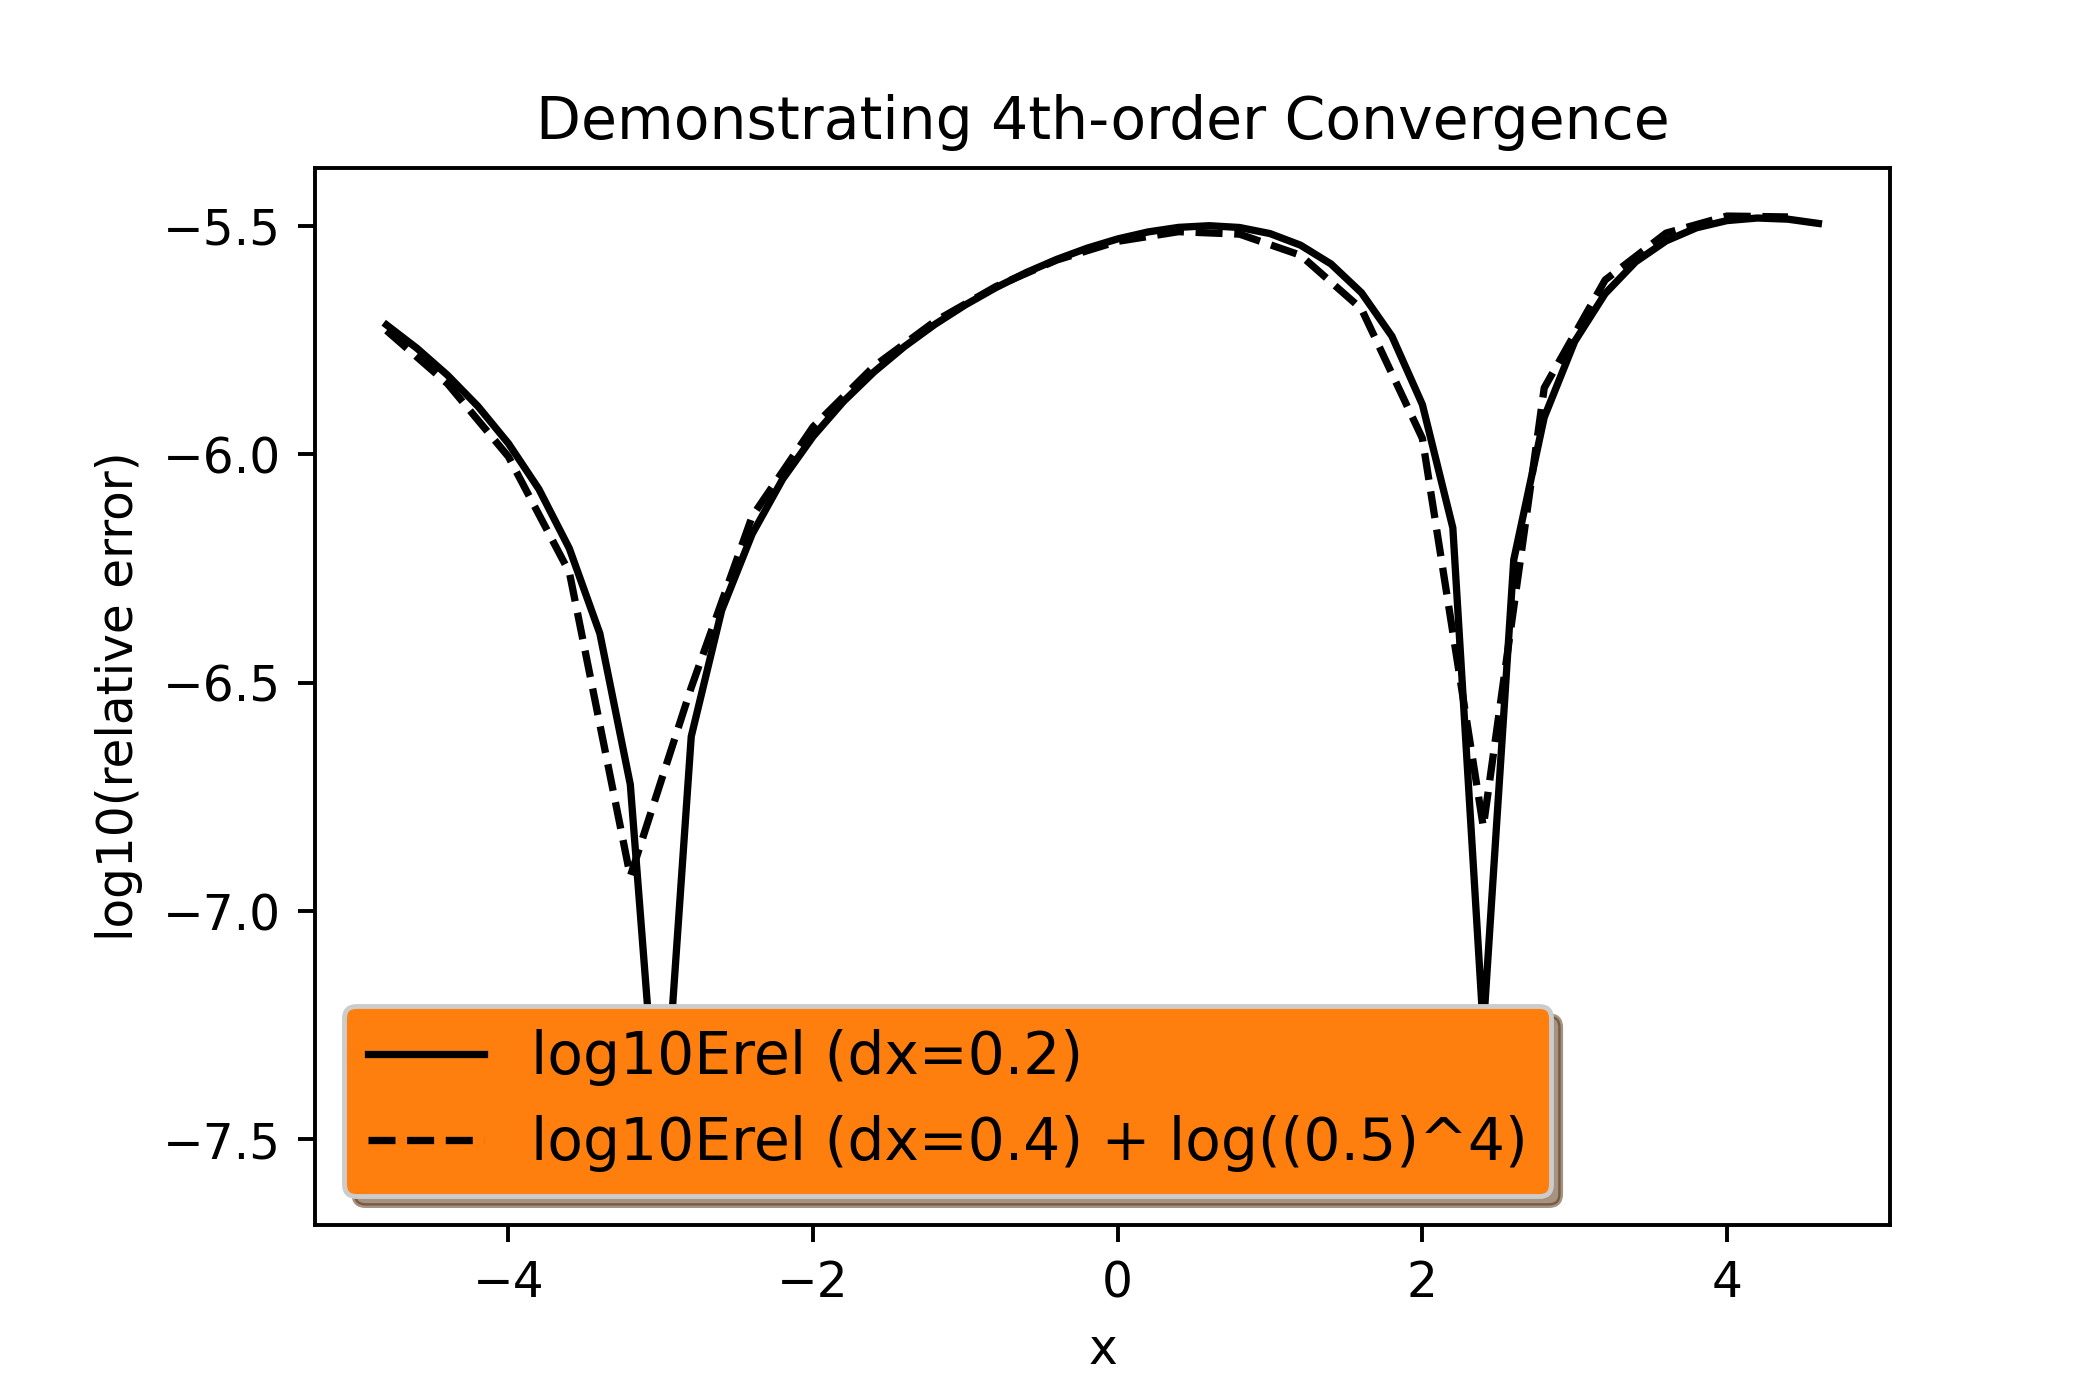

In [20]:
from IPython.display import Image
Image("./WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/convergence-RK4-FD4-3D.png", width=500, height=500)

#### Three-dimensional scalar wave equation code tests for monochromatic plane wave initial data adopting *eighth*-order finite differencing, coupled to *RK8* method-of-lines for time integration

Inside the directory *`WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTests/`* are the files used for this convergence test:
1. **planewave_along_3D_diagonal\*.par** : ETK parameter files needed for performing the 3D tests. These parameter files set up a sinusoidal plane wave propagating along the x=y=z diagonal of a 3D numerical grid that extends from -13.6 to +13.6 along the x-, y-, and z-axis (in units of $\omega=k=c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^8$, since we adopt eighth-order-convergent timestepping and spatial finite differencing.)
1. **runscript.sh** : Runs the cactus executable (assumed to be named *cactus_etilgrmhd-FD8*) for all of the above parameter files.
    1. **convert_IOASCII_1D_to_gnuplot.sh** : Used by **runscript.sh** to convert the 1D output from the execution into a format that [gnuplot](http://gnuplot.info/) can recognize.
1. **gnuplot_script** : Script for creating code validation convergence plots with [gnuplot](http://gnuplot.info/).

**Eighth-order code validation test results:**

The plot below shows the discrepancy between numerical and exact solutions to the scalar wave equation at two different resolutions: dashed is low resolution ($\Delta x_{\rm low}=0.4$) and solid is high resolution ($\Delta x_{\rm high}=0.2$). Since this test adopts **eighth**-order finite differencing for spatial derivatives and **eighth**-order Runge-Kutta (RK8) for timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^8 = (0.4/0.2)^8 = 2^8=256$ when going from low to high resolution, and after rescaling the error in the low-resolution case, we see that indeed it overlaps the low-resolution result quite nicely, confirming eighth-order convergence.

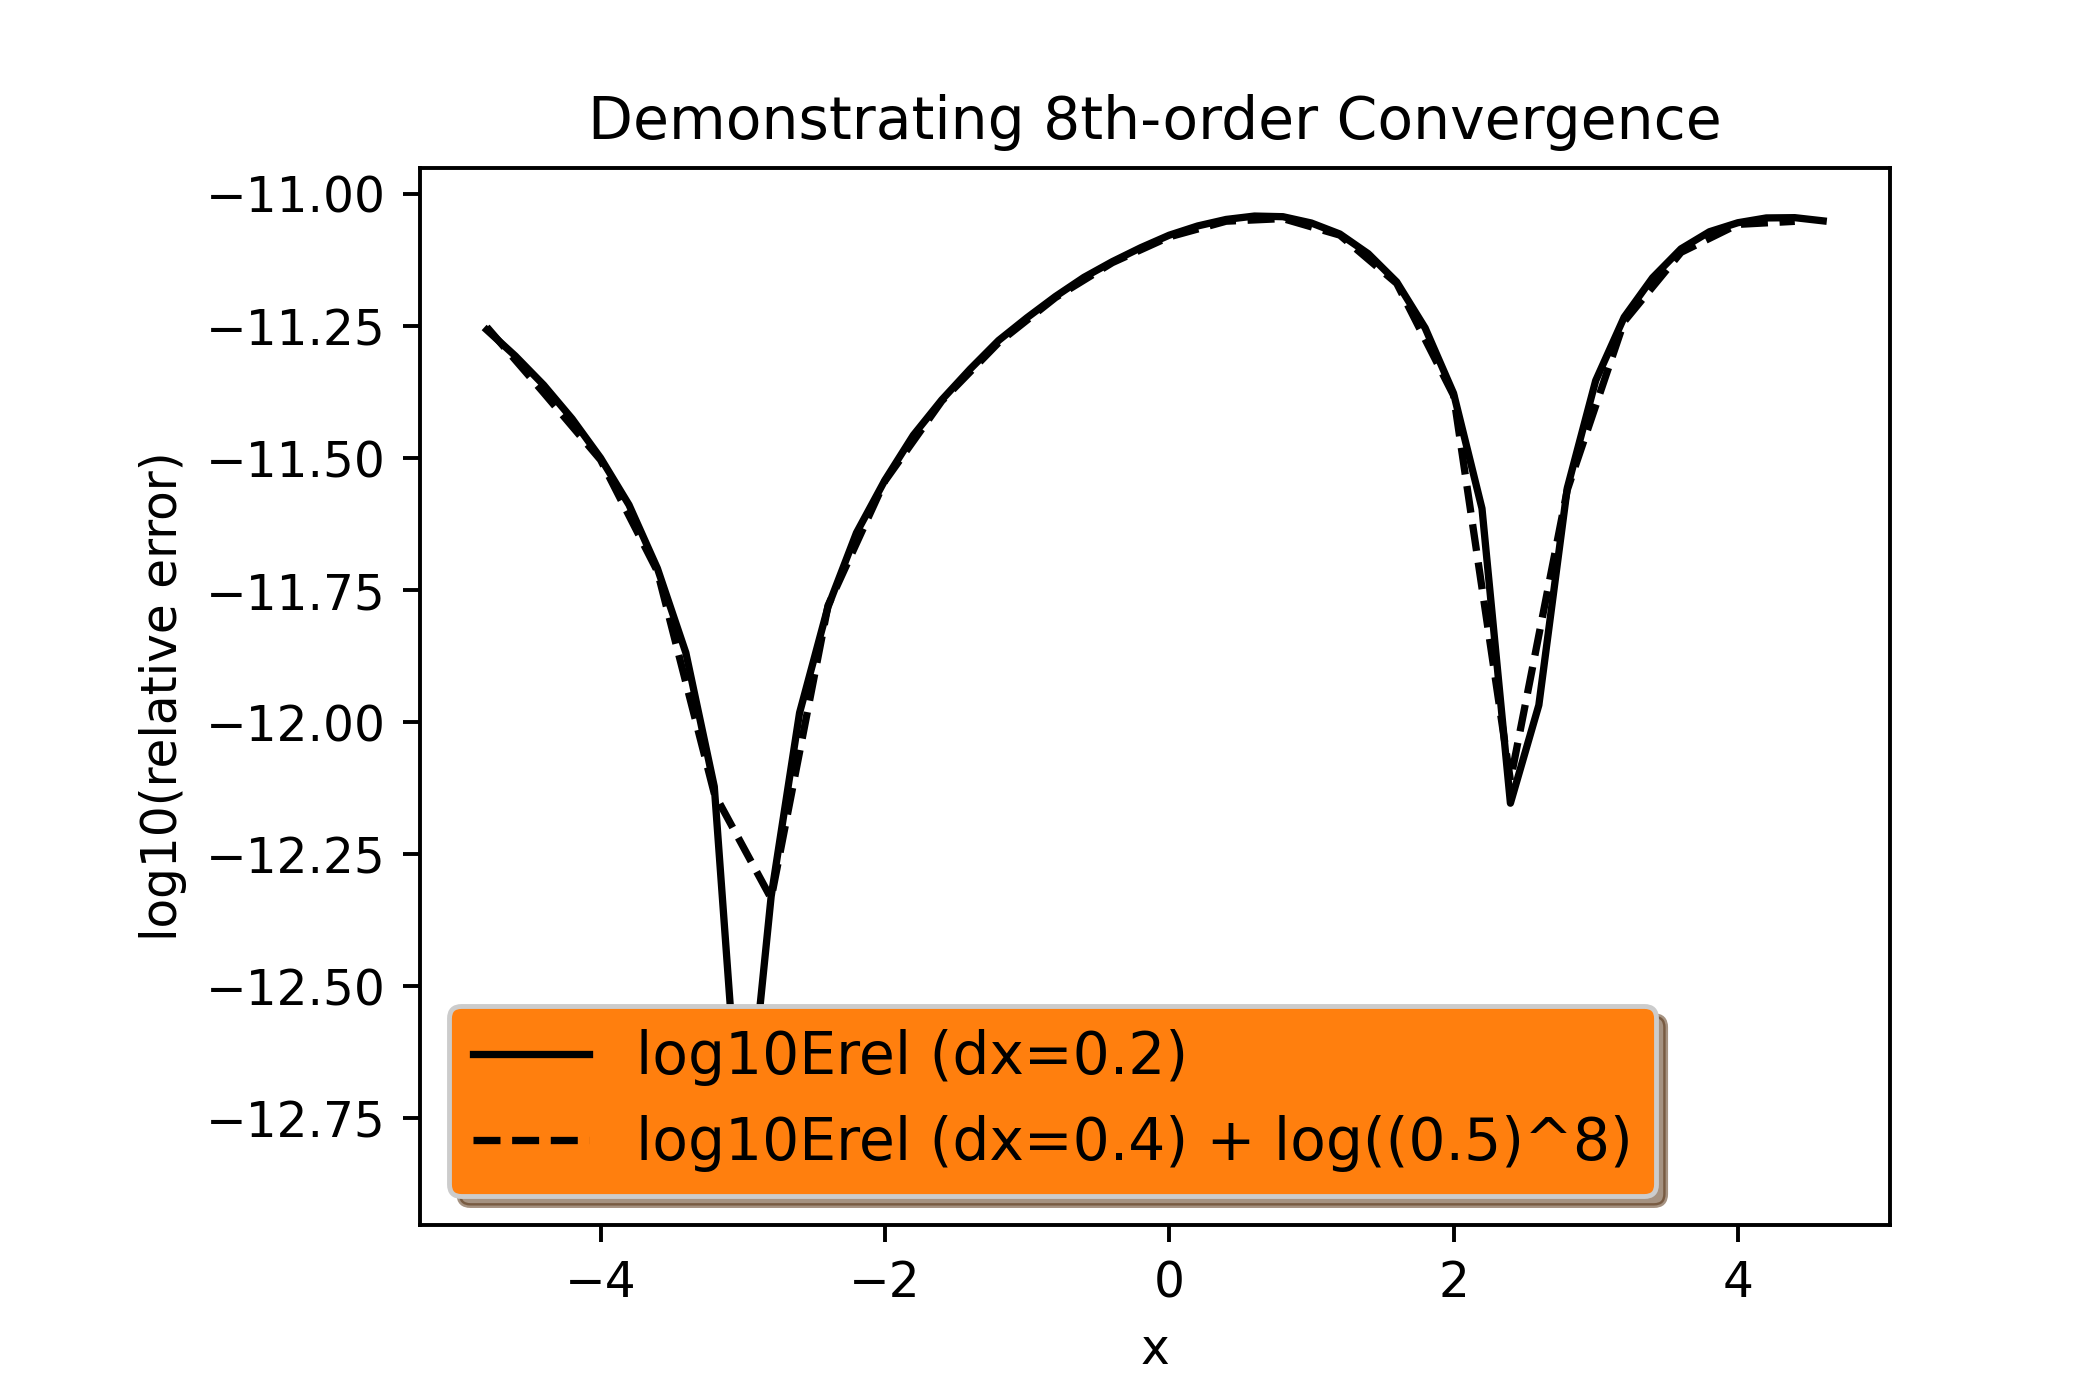

In [21]:
Image("WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTests/convergence-RK8-FD8-3D.png", width=500, height=500)

The NewRad boundary condition driver allows the wave within our numerical domain to propagate out through the boundary, with minimal reflections. Shown below is the full extent of the x-axis of our grid, [-13.6,13.6], and the wave amplitude at different times. We observe indeed that there are minimal reflections as the wave propagates to the right. Note the features on the left side of the wave that originate from the left boundary. These features are the resullt of the incorrect assumption that our wave propagates radially, as opposed to just along a single diagonal.

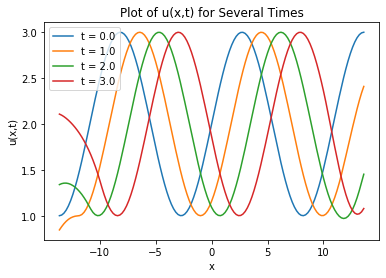

In [22]:
Image("WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTests/wavetimes.png", width=500, height=500)

<a id='gaussian'></a>

## Step 5.b: Spherical Gaussian Wave Convergence Tests \[Back to [top](#toc)\]
$$\label{gaussian}$$

**Three-dimensional scalar wave equation code tests, adopting fourth-order finite differencing, coupled to RK4 method-of-lines for time integration**

Inside the directory *`WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/`* are the files used for this convergence test:
**spherical_gaussian\*.par** : ETK parameter files needed for performing the 3D tests. These parameter files set up a spherical gaussian wave propagating in a 3D numerical grid that extends from -13.0 to +13.0 along the x-, y-, and z-axis (in units of $c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^4$, since we adopt eighth-order-convergent timestepping and spatial finite differencing.)

**Fourth-order code validation test results:**

The plot below shows the discrepancy between numerical and exact solutions to the scalar wave equation at two different resolutions: dashed is low resolution ($\Delta x_{\rm low}=0.4$) and solid is high resolution ($\Delta x_{\rm high}=0.2$). Since this test adopts **fourth**-order finite differencing for spatial derivatives and **fourth**-order Runge-Kutta (RK4) for timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^4 = (0.4/0.2)^4 = 2^4=16$ when going from low to high resolution, and after rescaling the error in the low-resolution case, we see that indeed it overlaps the low-resolution result quite nicely, confirming fourth-order convergence.

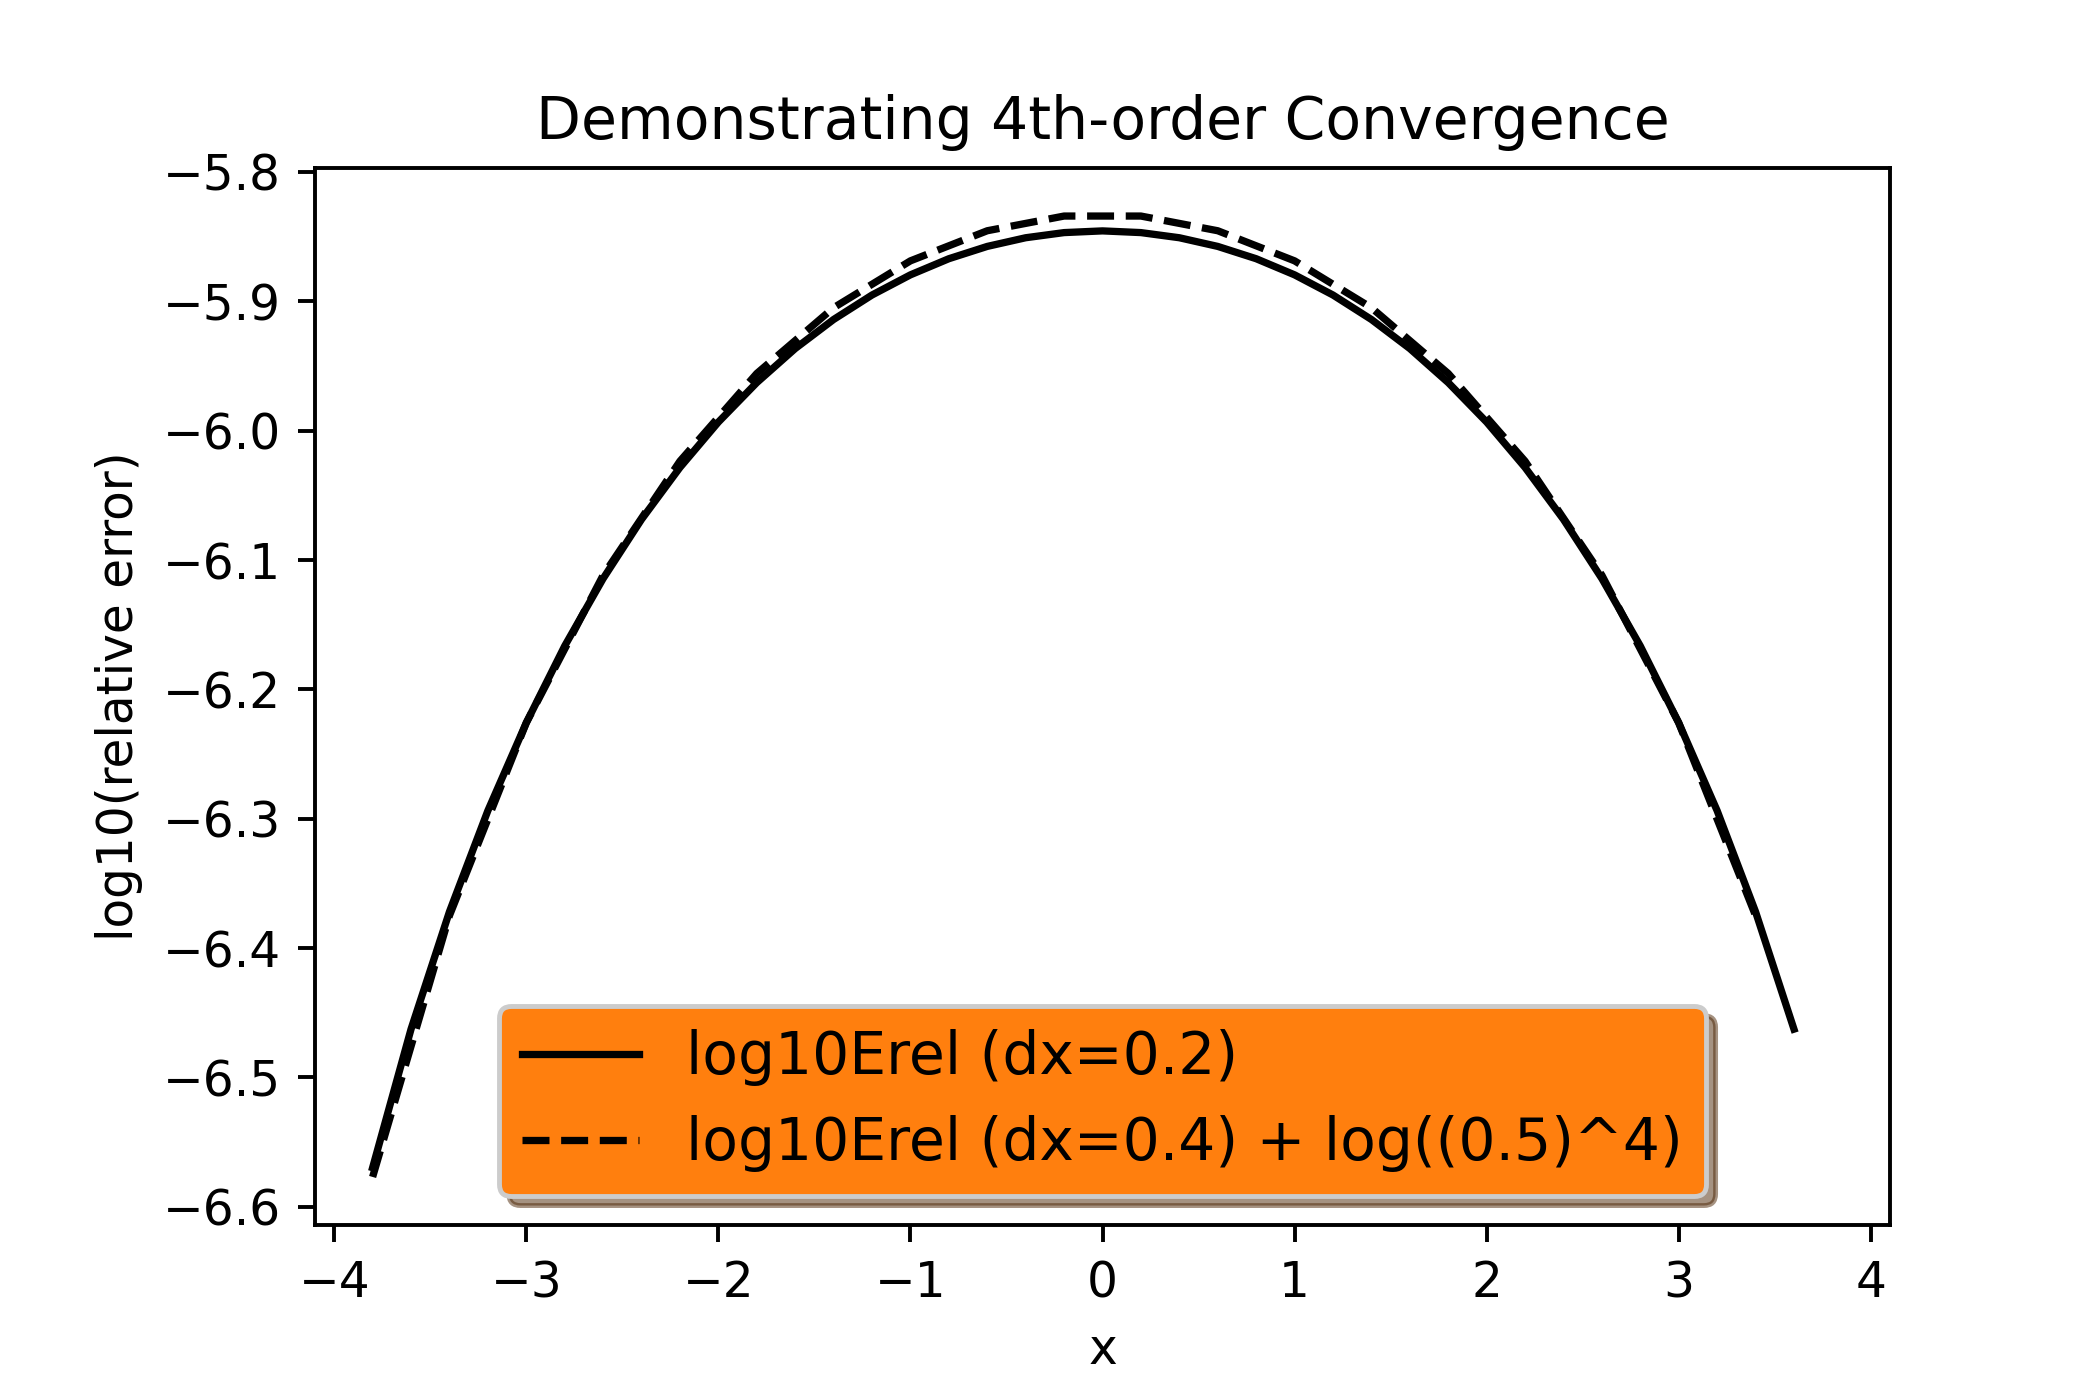

In [23]:
Image("WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/convergence-RK4-FD4-spherical_gaussian.png", width=500, height=500)

#### Three-dimensional scalar wave equation code tests for spherical gaussian initial data, adopting *eighth*-order finite differencing, coupled to *RK8* method-of-lines for time integration

Inside the directory *`WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTests/`* are the files used for this convergence test:
**spherical_gaussian\*.par** : ETK parameter files needed for performing the 3D tests. These parameter files set up a spherical gaussian wave propagating in a 3D numerical grid that extends from -13.8 to +13.8 along the x-, y-, and z-axis (in units of $c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^8$, since we adopt eighth-order-convergent timestepping and spatial finite differencing.)

**Eighth-order code validation test results:**

The plot below shows the discrepancy between numerical and exact solutions to the scalar wave equation at two different resolutions: dashed is low resolution ($\Delta x_{\rm low}=0.4$) and solid is high resolution ($\Delta x_{\rm high}=0.2$). Since this test adopts **eighth**-order finite differencing for spatial derivatives and **eighth**-order Runge-Kutta (RK8) for timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^8 = (0.4/0.2)^8 = 2^8=256$ when going from low to high resolution, and after rescaling the error in the low-resolution case, we see that indeed it overlaps the low-resolution result quite nicely, confirming eighth-order convergence.

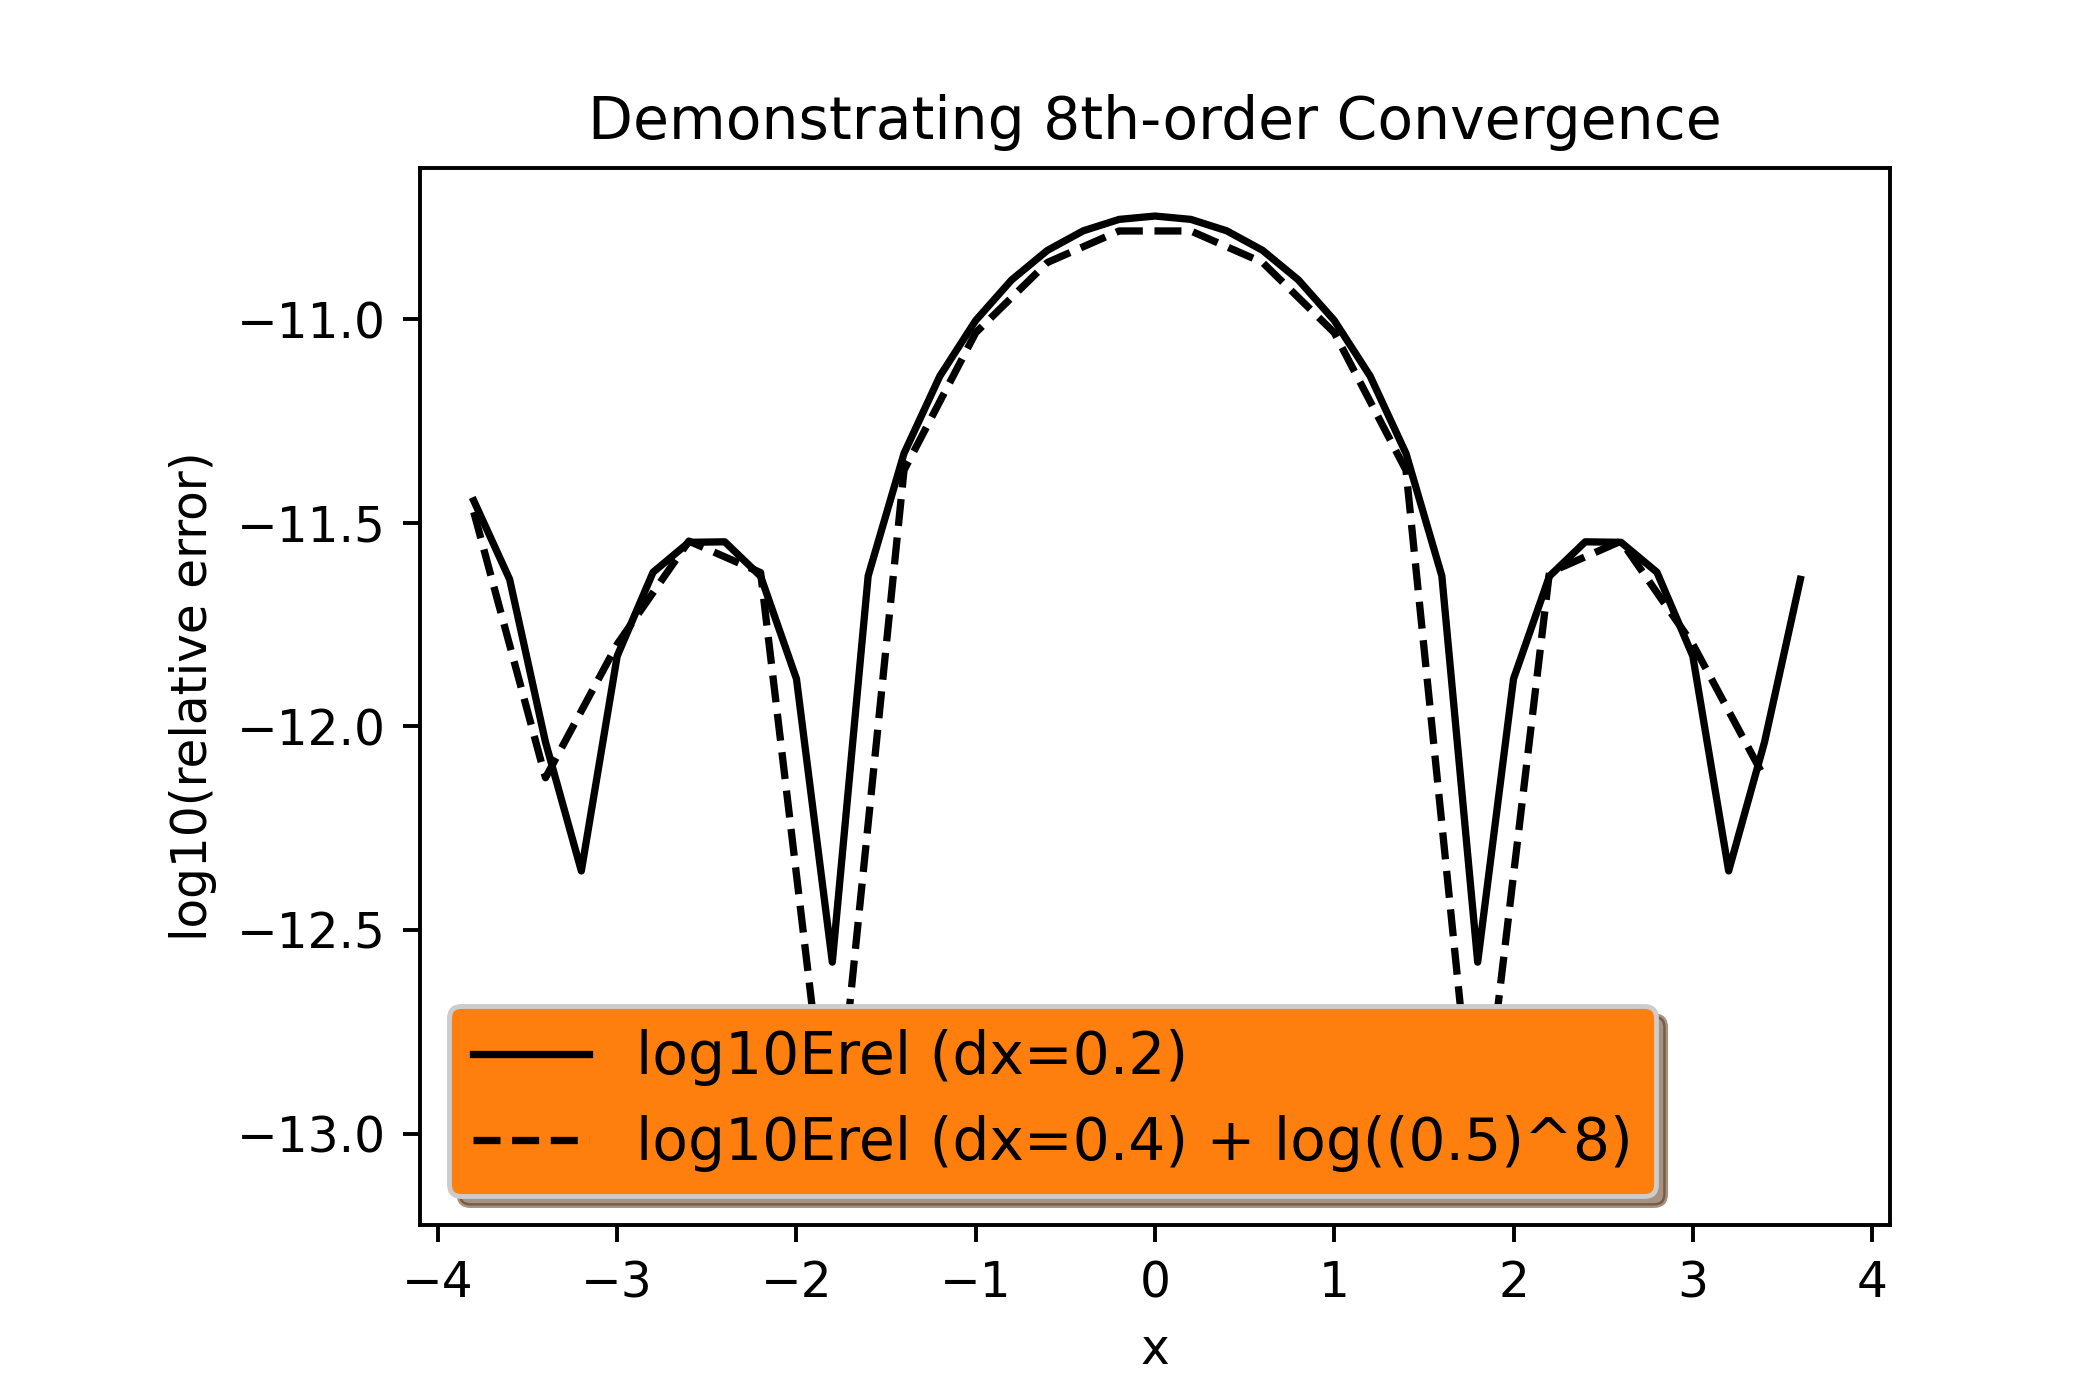

In [24]:
Image("WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTests/convergence-RK8-FD8-spherical_gaussian.png", width=500, height=500)

<a id='latex_pdf_output'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ETK_thorn-WaveToyNRPy.pdf](Tutorial-ETK_thorn-WaveToyNRPy.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [25]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-ETK_thorn-WaveToyNRPy")

Created Tutorial-ETK_thorn-WaveToyNRPy.tex, and compiled LaTeX file to PDF
    file Tutorial-ETK_thorn-WaveToyNRPy.pdf
